In [6]:
# Add these imports
import jax
import jax.numpy as jnp
from jax import vmap
import numpyro
import numpyro.distributions as dist
from numpyro import sample

# Constants
c = 299792.458  # speed of light in km/s

def H(z, H0, Om):
    """Hubble parameter at redshift z"""
    OL = 1 - Om  # Flat universe: Omega_Lambda = 1 - Omega_m
    return H0 * jnp.sqrt(jnp.maximum(Om * (1 + z)**3 + OL, 1e-10))

def luminosity_distance(z, Om, H0):
    """Calculate luminosity distance in Mpc"""
    # Simple rectangle rule integration for comoving distance
    N = 1000  # number of points
    z_array = jnp.linspace(0, z, N)
    dz = z_array[1] - z_array[0] # step size
    
    # Add small epsilon to prevent division by zero
    integrand_values = vmap(lambda z_: c / H(z_, H0, Om))(z_array)
    chi = jnp.sum(integrand_values) * dz
    
    # For flat universe, comoving distance equals proper distance
    return jnp.maximum((1 + z) * chi, 1e-10)  # Ensure positive distance

def distance_modulus(z, Om, H0):
    """Calculate distance modulus"""
    dL = luminosity_distance(z, Om, H0)
    return 5 * jnp.log10(jnp.maximum(dL, 1e-10)) + 25

# Vectorize the distance modulus calculation
distance_modulus_vec = vmap(distance_modulus, in_axes=(0, None, None))

def model(z, mu_obs, mu_err):
    # Priors
    H0 = sample("H0", dist.Uniform(60, 80))     # Uniform prior on H0
    Om = sample("Om", dist.Uniform(0.1, 0.9))   # Uniform prior on Omega_m
    
    # Calculate expected distance modulus
    mu_exp = distance_modulus_vec(z, Om, H0)
    
    # Likelihood (assuming independent measurements)
    sample("obs", dist.Normal(mu_exp, mu_err), obs=mu_obs)

In [10]:
# load data
import pandas as pd
df = pd.read_csv('Pantheon+SH0ES.dat', sep='\s+', header=0)

sample: 100%|██████████| 2201/2201 [00:27<00:00, 78.85it/s, 5 steps of size 5.72e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     73.05      0.26     73.05     72.59     73.45    488.33      1.00
        Om      0.35      0.02      0.35      0.32      0.38    482.33      1.00

Number of divergences: 0


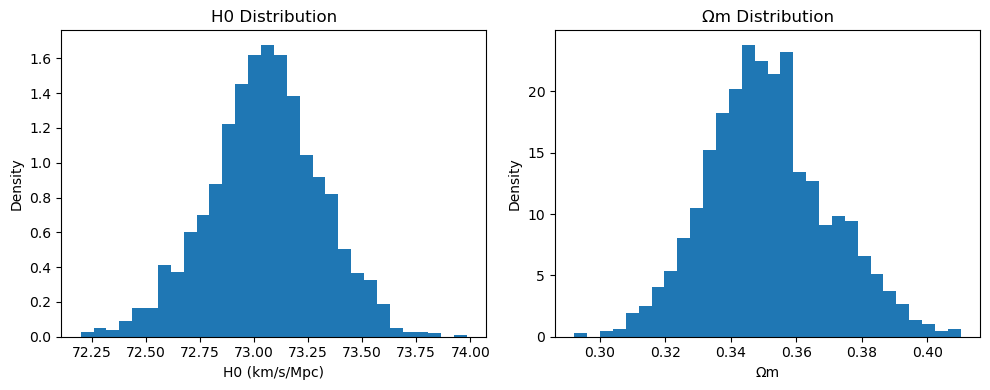

Infered Parameters:
H0: 73.05 ± 0.26
Ωm: 0.35 ± 0.02
OL: 0.65 ± 0.02


In [11]:
from numpyro.infer import MCMC, NUTS

# Prepare data
z = df['zHD'].values
mu = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

# Setup inference
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=len(z))

# Run inference
mcmc.run(jax.random.PRNGKey(0), z, mu, mu_err)

# Print results
mcmc.print_summary()

import matplotlib.pyplot as plt
# Get samples
samples = mcmc.get_samples()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot H0 histogram
ax1.hist(samples['H0'], bins=30, density=True)
ax1.set_xlabel('H0 (km/s/Mpc)')
ax1.set_ylabel('Density')
ax1.set_title('H0 Distribution')

# Plot Om histogram 
ax2.hist(samples['Om'], bins=30, density=True)
ax2.set_xlabel('Ωm')
ax2.set_ylabel('Density')
ax2.set_title('Ωm Distribution')

plt.tight_layout()
plt.show()

print("Infered Parameters:")
print("H0: {:.2f} ± {:.2f}".format(jnp.mean(samples['H0']), jnp.std(samples['H0'])))
print("Ωm: {:.2f} ± {:.2f}".format(jnp.mean(samples['Om']), jnp.std(samples['Om'])))
print("OL: {:.2f} ± {:.2f}".format(1-jnp.mean(samples['Om']), jnp.std(samples['Om'])))